# Load package and plot data

In [1]:
import os
import sys
import mmap

sys.path.append("/Users/zhd/Desktop/Research/Project/Dendritic data/code/")
#sys.path.append("/Users/zhd/packages/CaImAn/")
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import numpy as np
#import scipy as sp
import scipy.io as sio
import scipy.stats as ss
import superpixel_analysis as sup
import random
#import caiman as cm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF
from sklearn import linear_model

%load_ext autoreload
%autoreload 2

In [2]:
# Example movie extracted from https://github.com/simonsfoundation/CaImAn
data_dir='/Users/zhd/Desktop/Research/Project/Dendritic data/whole_data/'

In [3]:
out_dir ='/Users/zhd/Desktop/Research/Project/Dendritic data/result/first_try/'

In [4]:
#Y_orig =  np.memmap(data_dir+"Yr_d1_484_d2_477_d3_1_order_C_frames_3640_.mmap",dtype="float32",mode='r',shape=(477,484,3640),order='C')

In [4]:
Yd =  np.memmap(data_dir+"Yd.mmap",mode="r",dtype="float32", shape=(477,484,3640),order='F');

In [6]:
dims = Yd.shape;
T = dims[2];

In [7]:
Yt = np.memmap(data_dir+"Yt.mmap", dtype='float32', mode='r',shape=dims,order='F');

In [11]:
################## code to construct Yt (Yt can also be directly load as above) ##########################
Yt = sup.threshold_data(Yd)

# correlation analysis - find superpixels

In [8]:
cut_off_point = 0.9; ############# correlation threshold #############
length_cut = 10; ################## size threshold ##################

In [9]:
connect_mat_1, idx, comps, permute_col = sup.find_superpixel(Yt, cut_off_point, length_cut);

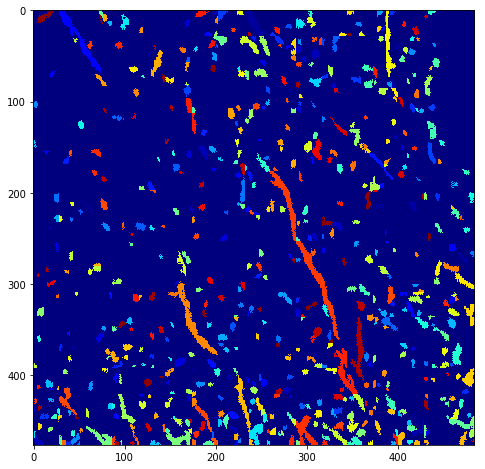

In [10]:
fig = plt.figure(figsize=(8,8));
plt.imshow(connect_mat_1,cmap='jet')
#fig.savefig(out_dir + "superpixels.pdf")

In [12]:
Cnt = sup.local_correlations_fft(Yt);

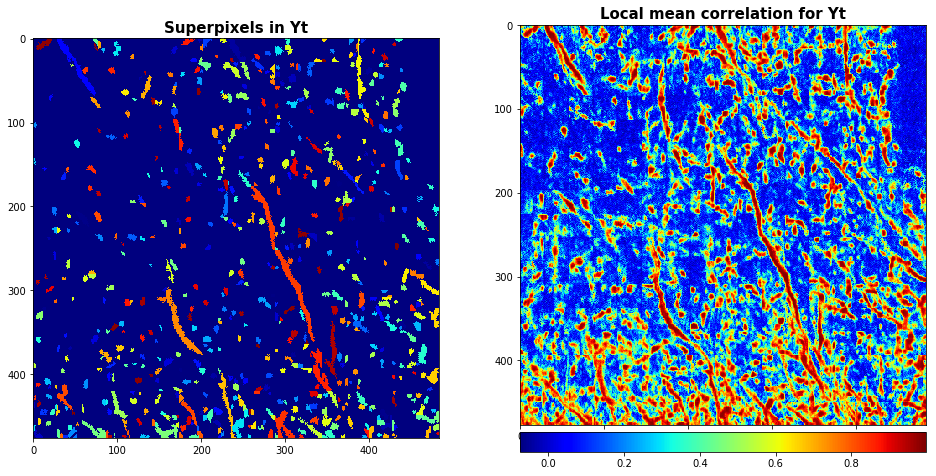

In [13]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1);
ax.imshow(connect_mat_1,cmap="jet");
ax.set(title="Superpixels in Yt")
ax.title.set_fontsize(15)
ax.title.set_fontweight("bold")

ax1 = plt.subplot(1,2,2);
sup.show_img(ax1, Cnt);
ax1.set(title="Local mean correlation for Yt")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")

# rank-1 svd - initialize temporal trace for superpixels

In [14]:
V_mat, U_mat, B_mat = sup.spatial_temporal_ini(Yt, comps, idx, length_cut, maxiter=5, whole_data=True);

In [15]:
Ys_r = np.matmul(U_mat, V_mat.T) + B_mat.sum(axis=1).reshape(np.prod(dims[:2]),1)
Ys = Ys_r.reshape(dims[0],dims[1],T,order="F");

# SPA - find pure superpixel

In [58]:
################### specify a small region to find out all the pure superpixels in this region, use for habanero ##################
patch_height = 100;
patch_width = 100;
num_patch=25;
patch_ref_mat = np.array(range(num_patch)).reshape(int(np.ceil(dims[0]/patch_height)),int(np.ceil(dims[1]/patch_width)),order="F");
patch_ref_mat

array([[ 0,  5, 10, 15, 20],
       [ 1,  6, 11, 16, 21],
       [ 2,  7, 12, 17, 22],
       [ 3,  8, 13, 18, 23],
       [ 4,  9, 14, 19, 24]])

In [186]:
################### specify a small region to find out all the pure superpixels in this region ##################
pos = np.where(patch_ref_mat==0);
up=pos[0][0]*patch_height;
down=min(up+patch_height, dims[0]);
left=pos[1][0]*patch_width;
right=min(left+patch_width, dims[1]);

In [187]:
unique_pix, M = sup.search_superpixel_in_range([up,down],[left,right], connect_mat_1, permute_col, V_mat);

In [188]:
pure_pixels, coef, coef_rank = sup.fast_sep_nmf(M, M.shape[1], 0.6);

## Check each superpixel is composed by which pure superpixels

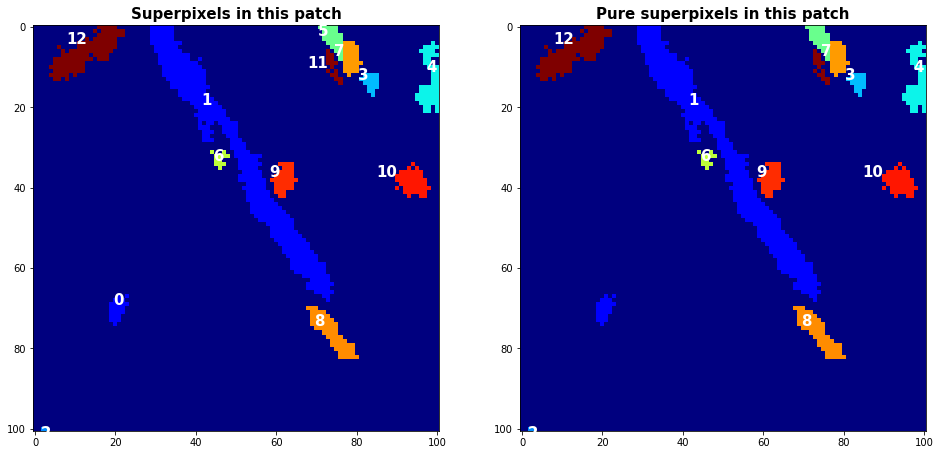

In [189]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1);
ax.imshow(connect_mat_1[up:(down+1),left:(right+1)],cmap="jet");

for ii in range(len(unique_pix)):
    pos = np.where(connect_mat_1[:,:] == unique_pix[ii]);
    pos0 = pos[0] - up;
    pos1 = pos[1] - left;
    ax.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)+5], f"{ii}",
        verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
ax.set(title="Superpixels in this patch")
ax.title.set_fontsize(15)
ax.title.set_fontweight("bold")

ax1 = plt.subplot(1,2,2);
ax1.imshow(connect_mat_1[up:(down+1),left:(right+1)],cmap="jet");

for ii in range(len(pure_pixels)):
    pos = np.where(connect_mat_1[:,:] == unique_pix[pure_pixels[ii]]);
    pos0 = pos[0] - up;
    pos1 = pos[1] - left;
    ax1.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)+5], f"{pure_pixels[ii]}",
        verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
ax1.set(title="Pure superpixels in this patch")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")

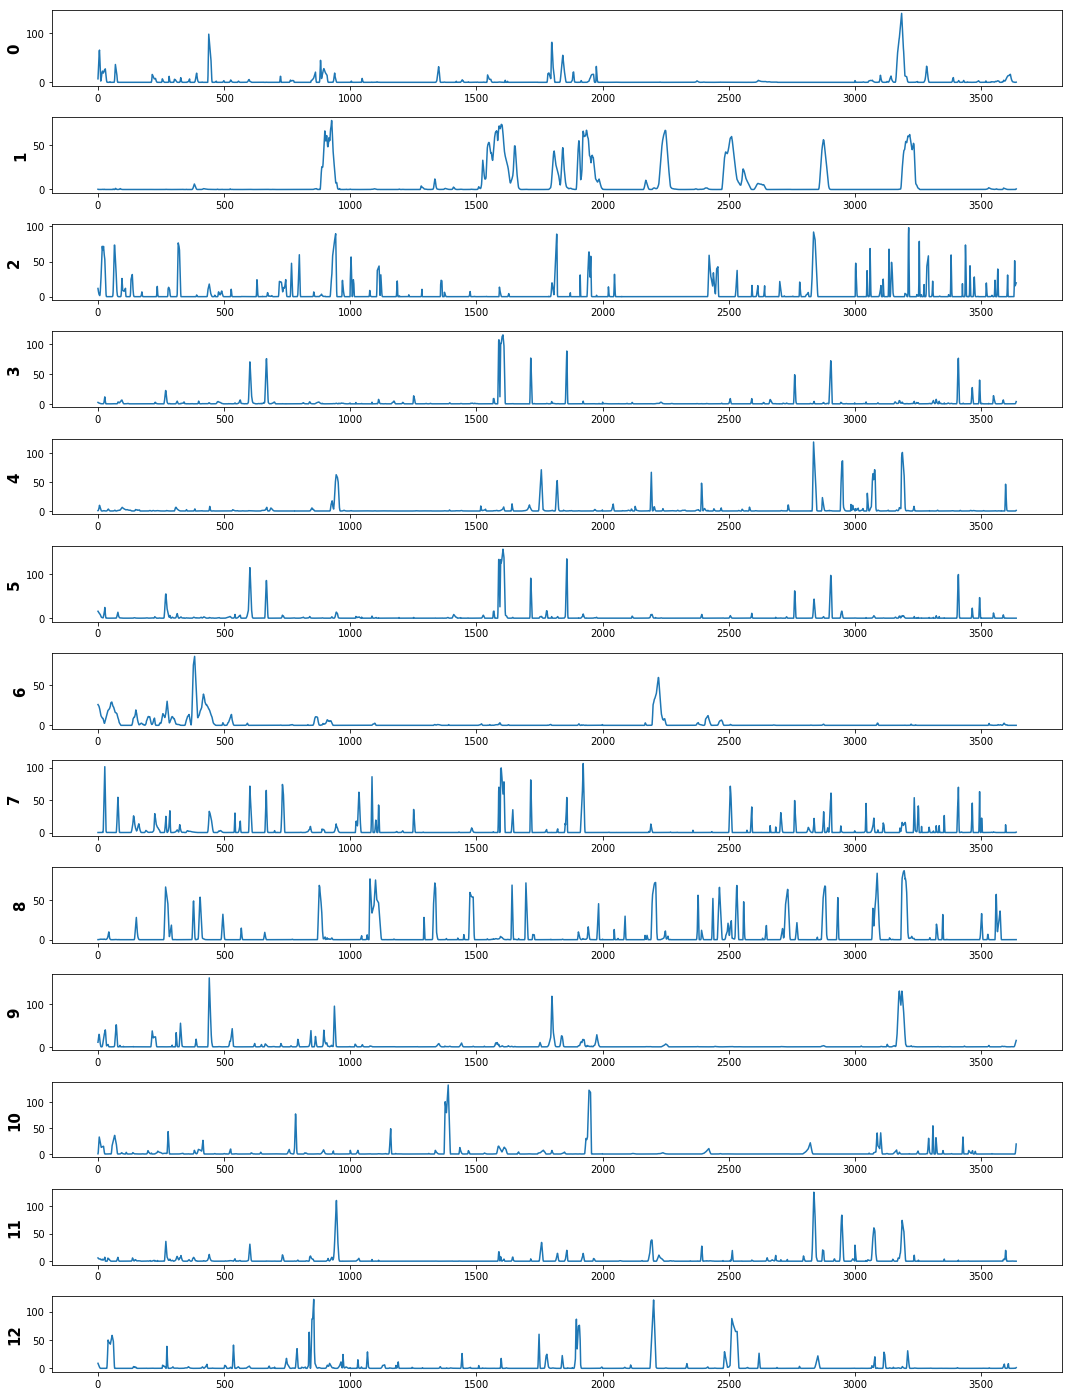

In [190]:
fig = plt.figure(figsize=(15,1.5*len(unique_pix)));
for ii in range(len(unique_pix)):
    plt.subplot(len(unique_pix),1,ii+1);
    plt.ylabel(str(ii),fontweight="bold",fontsize=15)
    pos = np.where(permute_col == unique_pix[ii])[0][0];
    plt.plot(V_mat[:,pos]);
plt.tight_layout()

In [191]:
np.corrcoef(V_mat[:,np.where(permute_col == unique_pix[1])[0][0]],
            V_mat[:,np.where(permute_col == unique_pix[9])[0][0]])

array([[1.        , 0.09321314],
       [0.09321314, 1.        ]])

In [193]:
coef_rank[:,0]

array([ 9.,  8., 10.,  4.,  1.,  3.,  6., 12.,  2.,  7.])

# visualize pure superpixels

In [194]:
a_ini, c_ini, y0, brightness_rank, pure_pix, corr_img_all_r = sup.prepare_iteration(Yt, connect_mat_1, permute_col, unique_pix, pure_pixels, V_mat, U_mat, [up,down],[left,right])

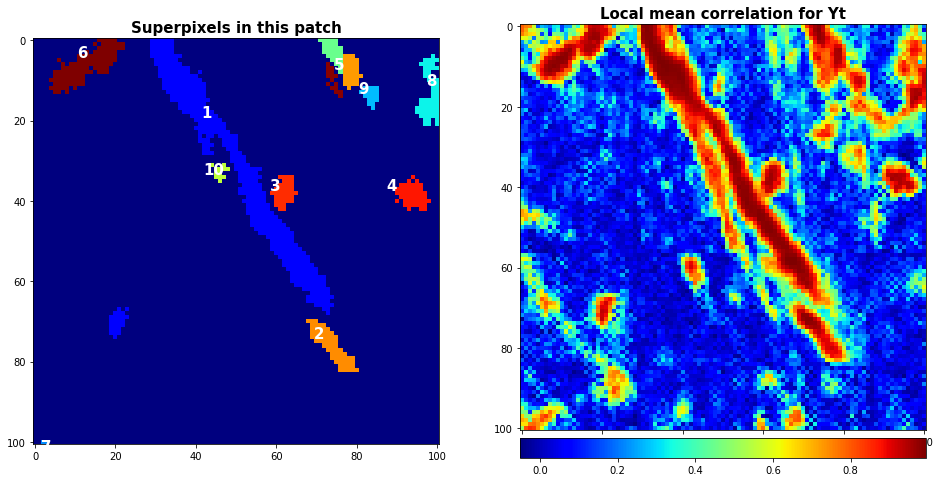

In [195]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1);
ax.imshow(connect_mat_1[up:(down+1),left:(right+1)],cmap="jet");

for ii in range(len(pure_pix)):
    pos = np.where(connect_mat_1[:,:] == pure_pix[ii]);
    pos0 = pos[0] - up;
    pos1 = pos[1] - left;
    ax.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)+5], f"{brightness_rank[ii]}",
        verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
ax.set(title="Superpixels in this patch")
ax.title.set_fontsize(15)
ax.title.set_fontweight("bold")

ax1 = plt.subplot(1,2,2);
sup.show_img(ax1, Cnt[up:(down+1),left:(right+1)]);
ax1.set(title="Local mean correlation for Yt")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")
#fig.savefig(out_dir + "labeled_fig_patch2.pdf")

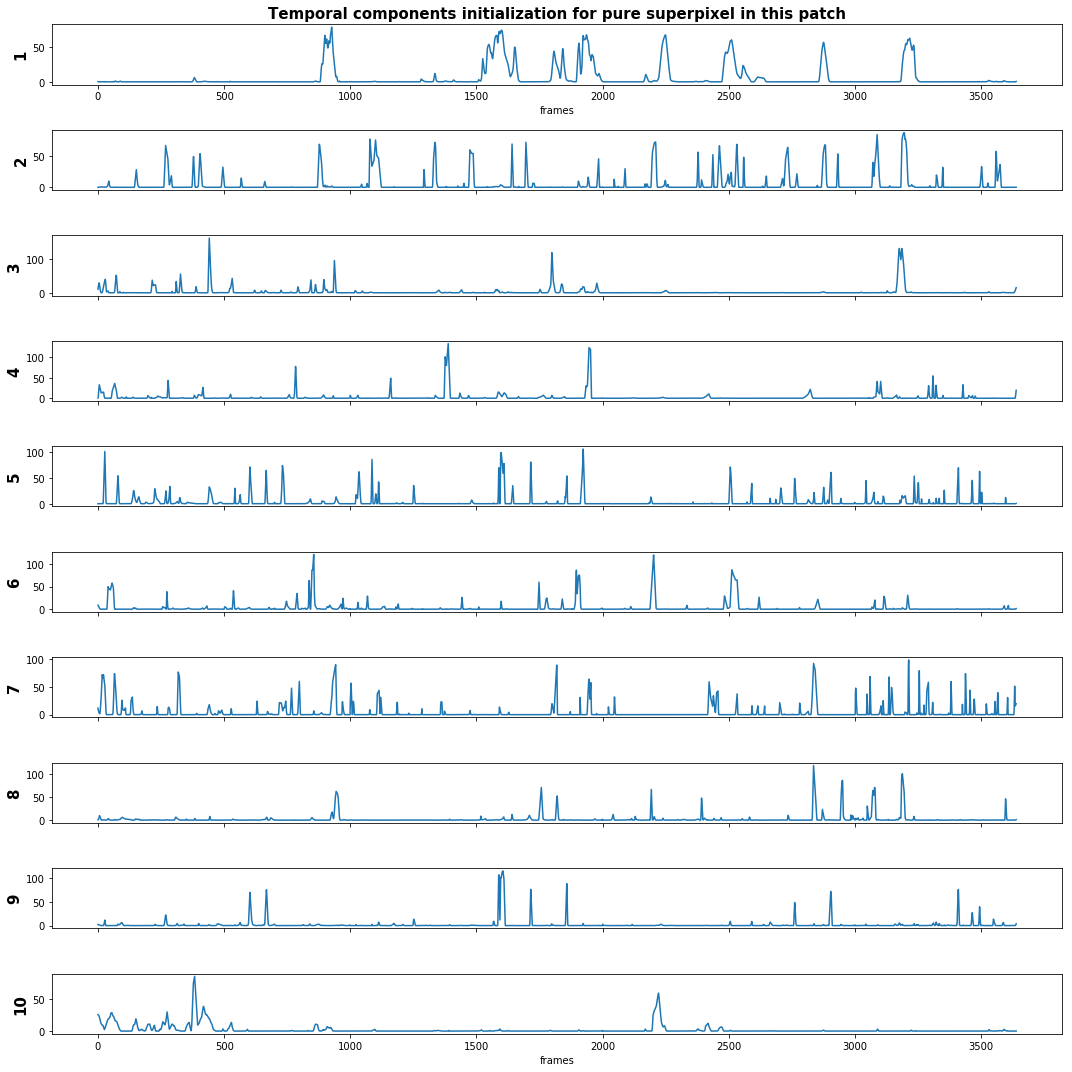

In [196]:
num = len(pure_pix);
fig = plt.figure(figsize=(15,1.5*num))
#fig = plt.figure(figsize=(15,1.5*8))
for ii in range(num):
    plt.subplot(num,1, ii+1);
    plt.plot(c_ini[:,ii]);
    if ii == 0:
        plt.title("Temporal components initialization for pure superpixel in this patch",fontweight="bold",fontsize=15);
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout()
#fig.savefig(out_dir + "pure_superpixel_temp_trace_patch2.pdf")

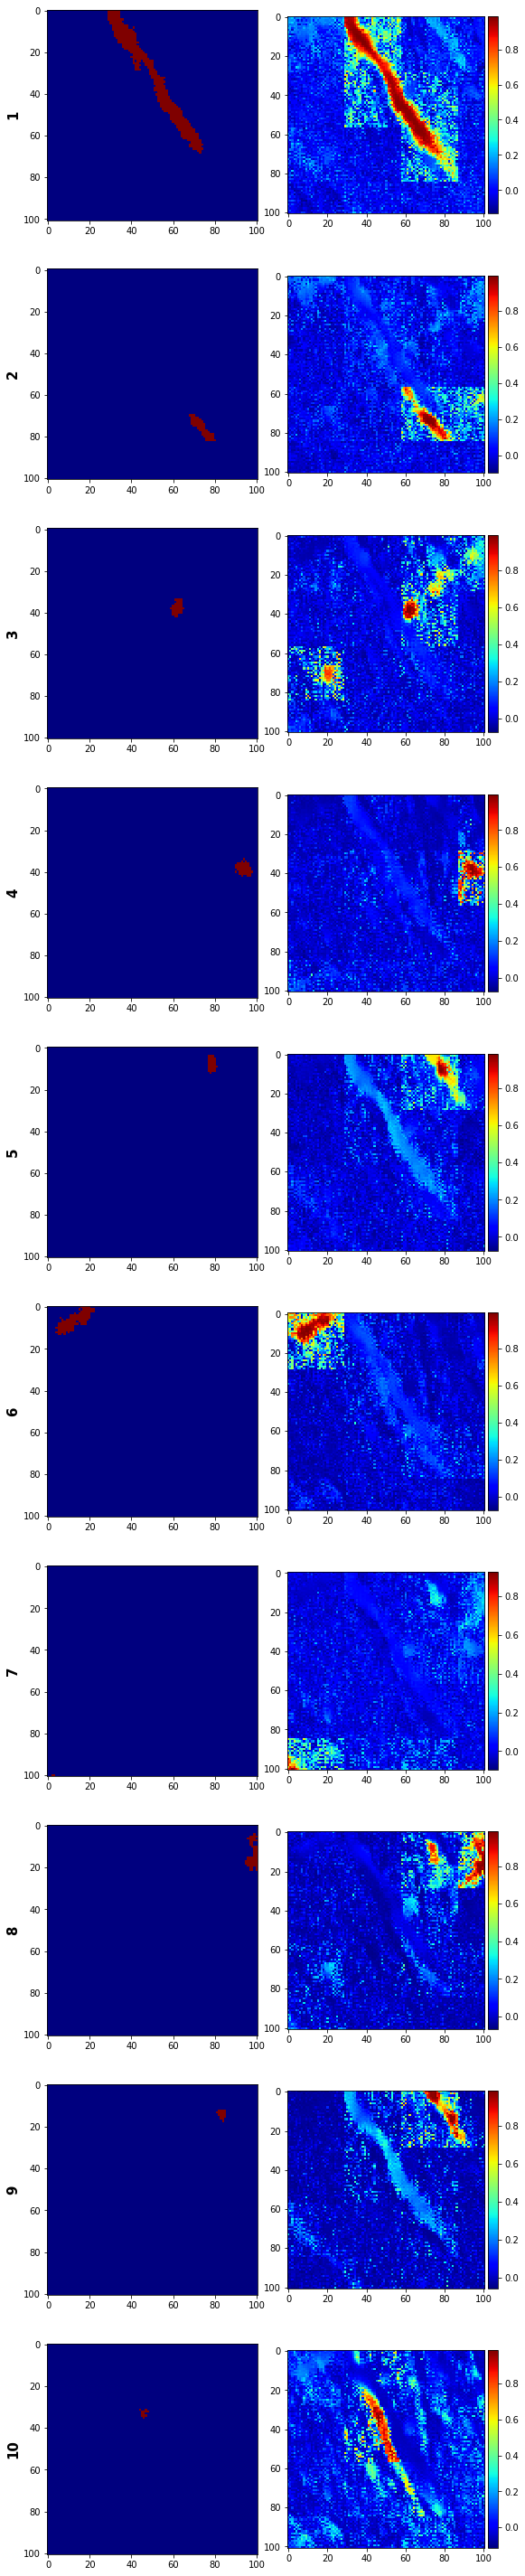

In [197]:
num = len(pure_pix);
fig = plt.figure(figsize=(8,num*4));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(connect_mat_1[up:(down+1),left:(right+1)] == pure_pix[np.where(brightness_rank == ii+1)[0]],cmap="jet");
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15);
    #plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax=plt.subplot(num,2,2*(ii+1));
    fig2=ax.imshow(corr_img_all_r[:,:,ii],cmap="jet");
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(fig2,cax=cax, orientation='vertical')
fig.tight_layout();
#fig.savefig(out_dir + "superpixel_corr_full.pdf")

# Iteratively update A and C

In [30]:
###################### test vanilla nmf #####################################
model = NMF(n_components=len(pure_pixels), init='random', random_state=0)
W = model.fit_transform(y0)
H = model.components_

In [104]:
###################### test nmf with initialization ##########################
model = NMF(n_components=len(pure_pixels), init='custom')
W1 = model.fit_transform(y0, W=a_ini.copy(), H = abs(c_ini.T));
H1 = model.components_

In [198]:
corr_th_ini = 0.8;
corr_th_dilate = [0.5];
corr_th_fix = 0.3;
maxiter=100;
tol=1e-8;
a, a_ini, c, c_ini, b, res = sup.update_AC_l2(y0, c_ini, corr_img_all_r, corr_th_ini, 
                                                    corr_th_fix, corr_th_dilate, dilate_times=2, 
                                                    maxiter=maxiter, tol=tol, whole_data=True);

correct number of correlation threshold!
2.1211086083284406e-09


In [199]:
corr_th_ini = 0.8;
corr_th_dilate = [0.5];
corr_th_fix = 0.3;
maxiter=100;
tol=1e-8;
maxiter_nr=100;
tol_nr=1;
a3, a_ini3, c3, c_ini3, b3, res3 = sup.update_AC_huber(y0, c_ini, corr_img_all_r, 
                                                   corr_th_ini, corr_th_fix,
                                                   corr_th_dilate, dilate_times=2, 
                                                   maxiter=maxiter, tol=tol, maxiter_nr=maxiter_nr, tol_nr=tol_nr);

correct number of correlation threshold!
2.5623989423879035e-05


# visualize NMF results

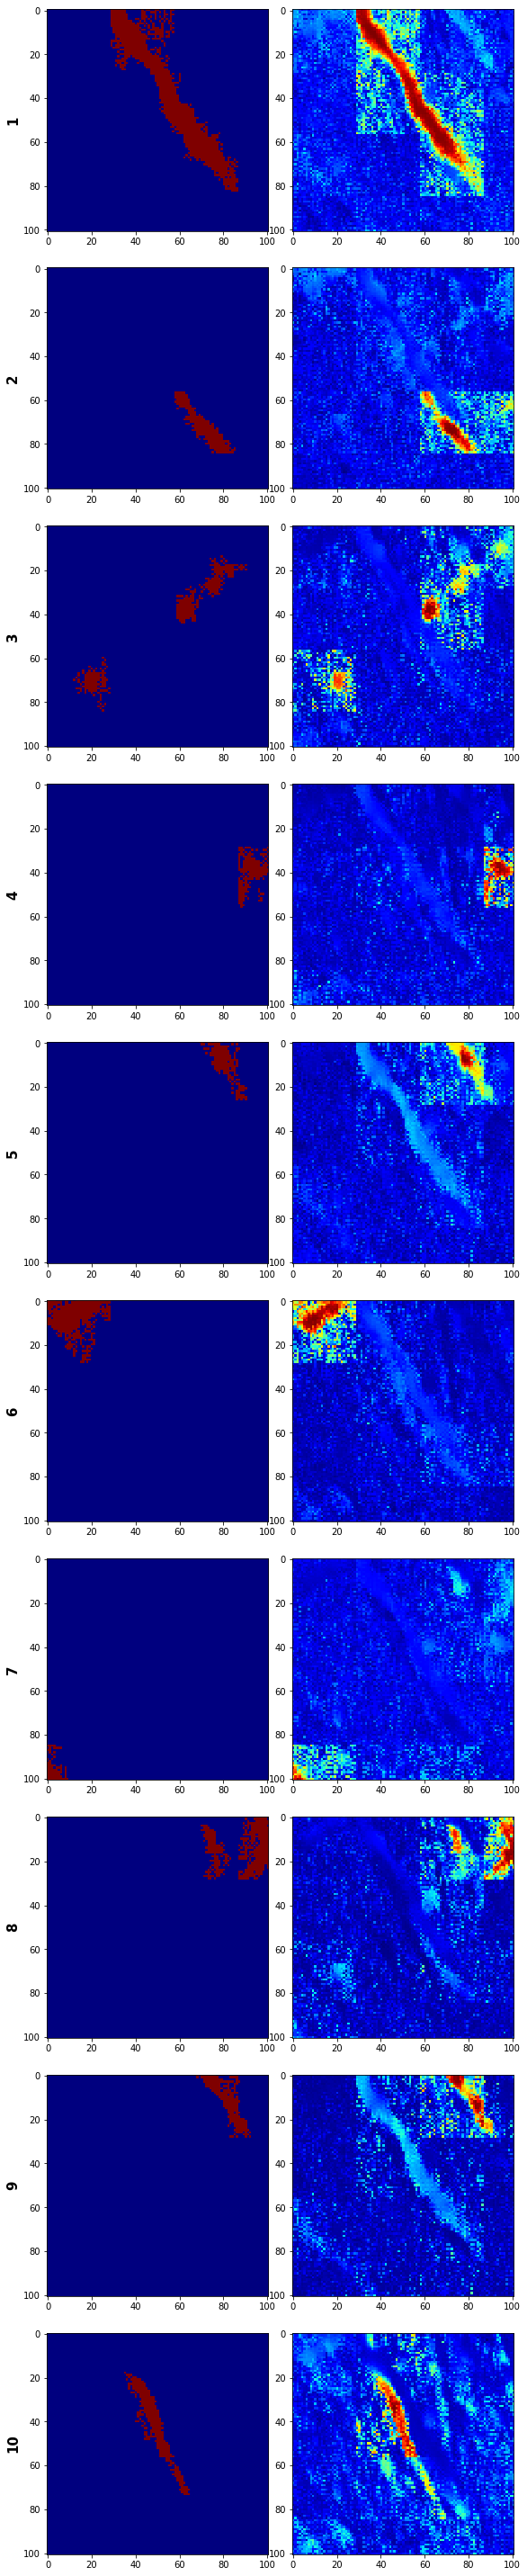

In [200]:
num=len(pure_pix);
fig = plt.figure(figsize=(8,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(a3[:,ii].reshape((down-up+1),(right-left+1),order="F")>0,cmap='jet');
    plt.ylabel(str(ii+1),fontsize=15,fontweight="bold");
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_r[:,:,ii],cmap='jet');  
fig.tight_layout()
#fig.savefig(out_dir + "spatial_huber_constrain_patch_2.pdf")

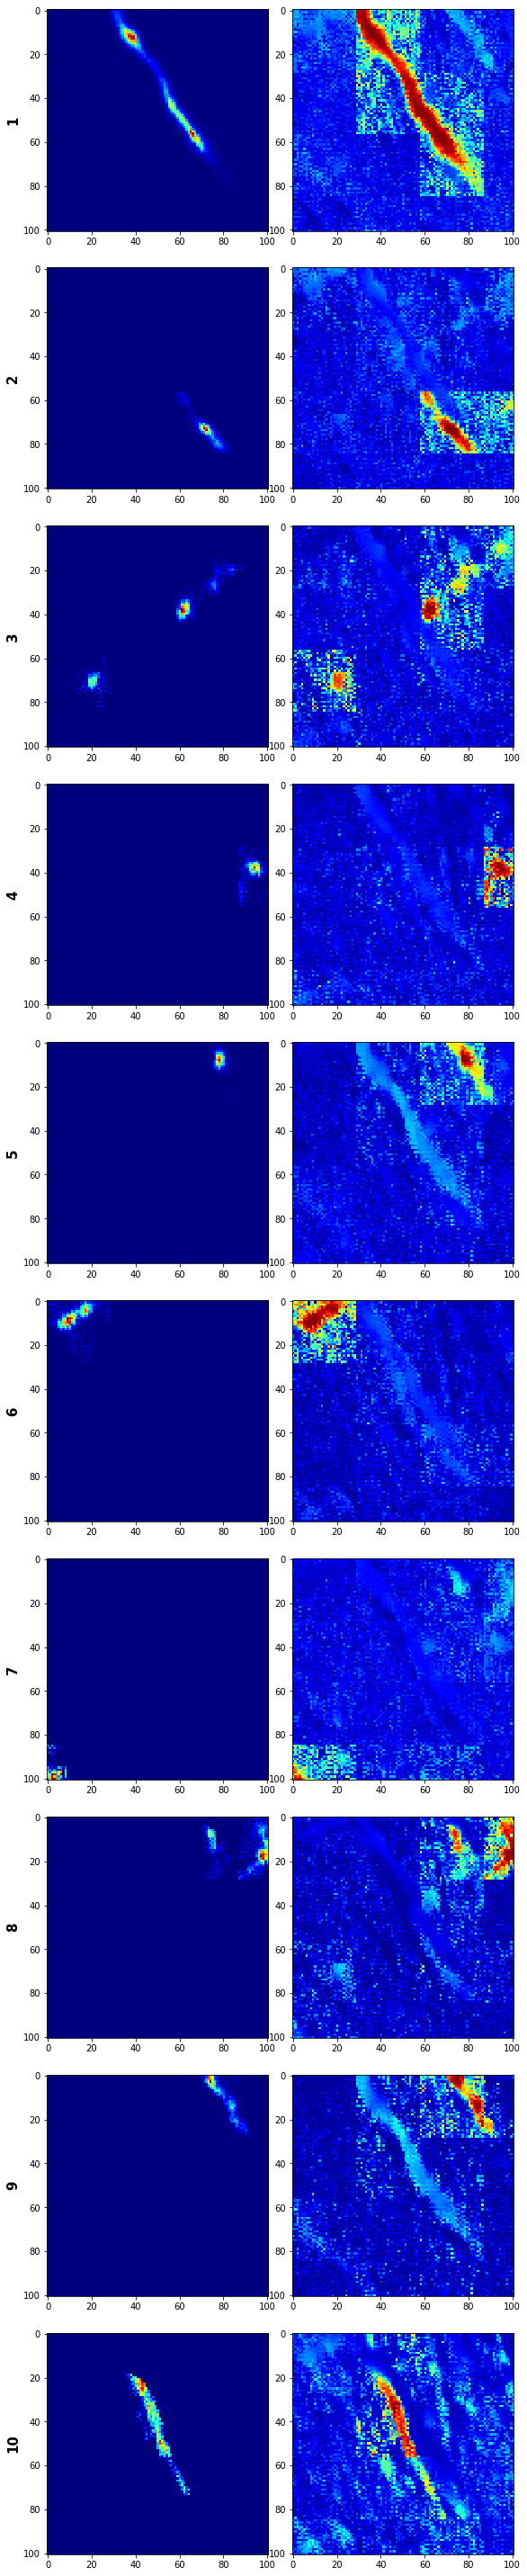

In [202]:
num=len(pure_pix);
fig = plt.figure(figsize=(8,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(a[:,ii].reshape((down-up+1),(right-left+1),order="F"),cmap='jet');
    plt.ylabel(str(ii+1),fontsize=15,fontweight="bold");
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_r[:,:,ii],cmap='jet');  
fig.tight_layout()
#fig.savefig(out_dir + "spatial_constriant_patch2.pdf")

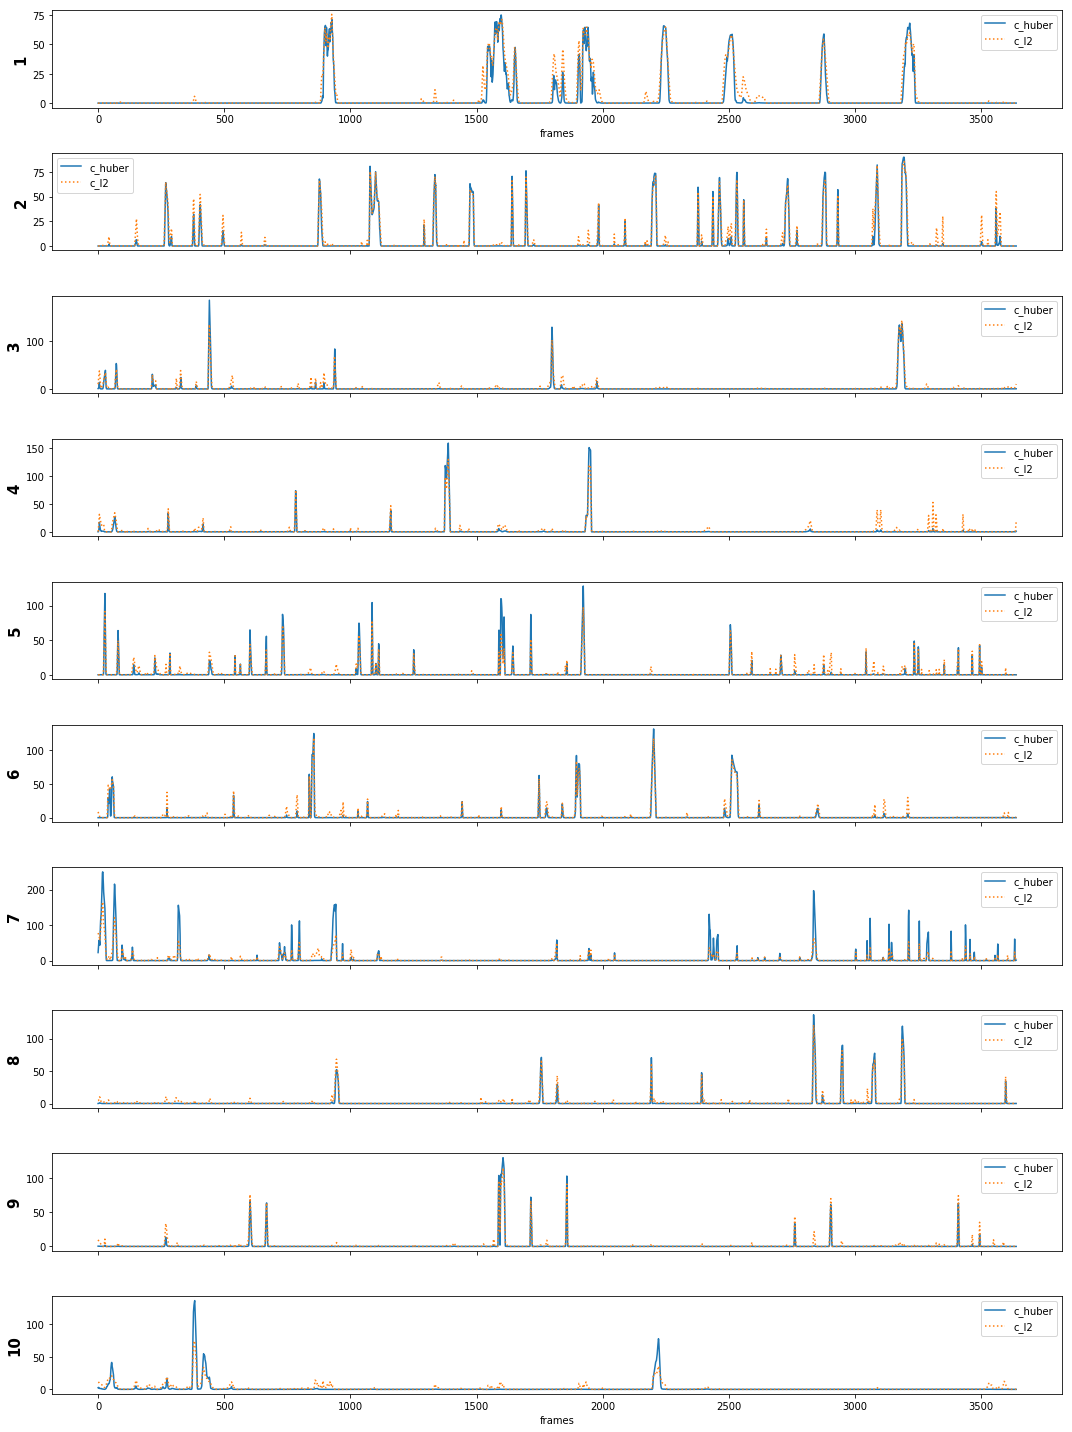

In [203]:
num=len(pure_pix);
fig = plt.figure(figsize=(15,2*num));
for ii in range(num):
    plt.subplot(num,1,ii+1);
    plt.plot(c3[:,ii],label="c_huber");
    plt.plot(c[:,ii],label="c_l2",linestyle=":");
    plt.legend()
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout();
#fig.savefig(out_dir + "temporal_huber_constriant_patch2.pdf")

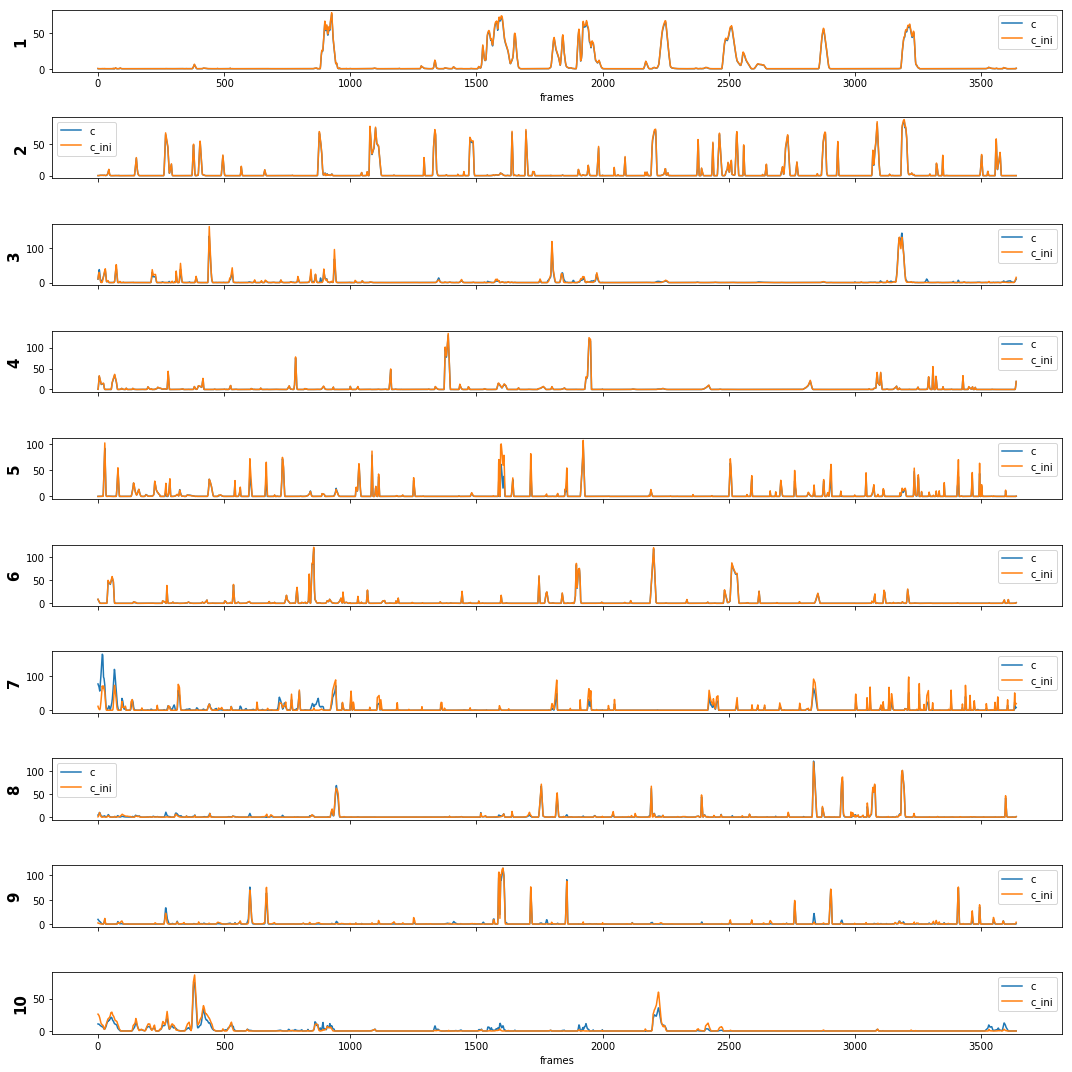

In [134]:
num=len(pure_pix);
fig = plt.figure(figsize=(15,1.5*num));
for ii in range(num):
    plt.subplot(num,1,ii+1);
    plt.plot(c[:,ii],label="c");
    plt.plot(c_ini[:,ii],label="c_ini");
    plt.legend()
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout();
#fig.savefig(out_dir + "temp_constrain_patch2.pdf")

In [195]:
corr_img_all = np.zeros([(down-up+1)*(right-left+1), len(pure_pix)]);
for ii in range(len(pure_pix)):
    corr_img_all[:,ii] = sup.vcorrcoef(y0, H1[ii,:]);
corr_img_all_rw1 = corr_img_all.reshape((down-up+1),(right-left+1),len(pure_pix),order="F");

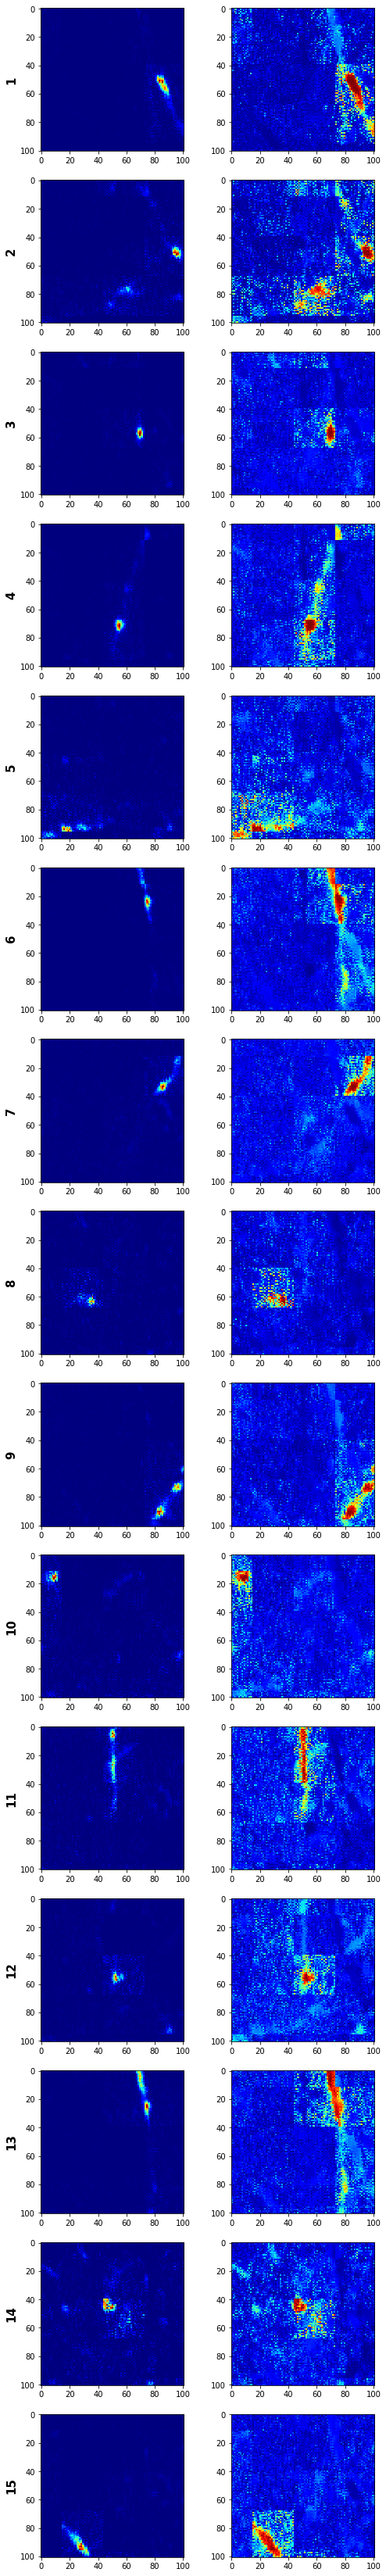

In [197]:
num=len(pure_pix);
fig = plt.figure(figsize=(8,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(W1[:,ii].reshape((down-up+1),(right-left+1),order="F"),cmap='jet');
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_rw1[:,:,ii],cmap='jet');  
fig.tight_layout()
#fig.savefig(out_dir + "spatial_nmf_patch2.pdf")

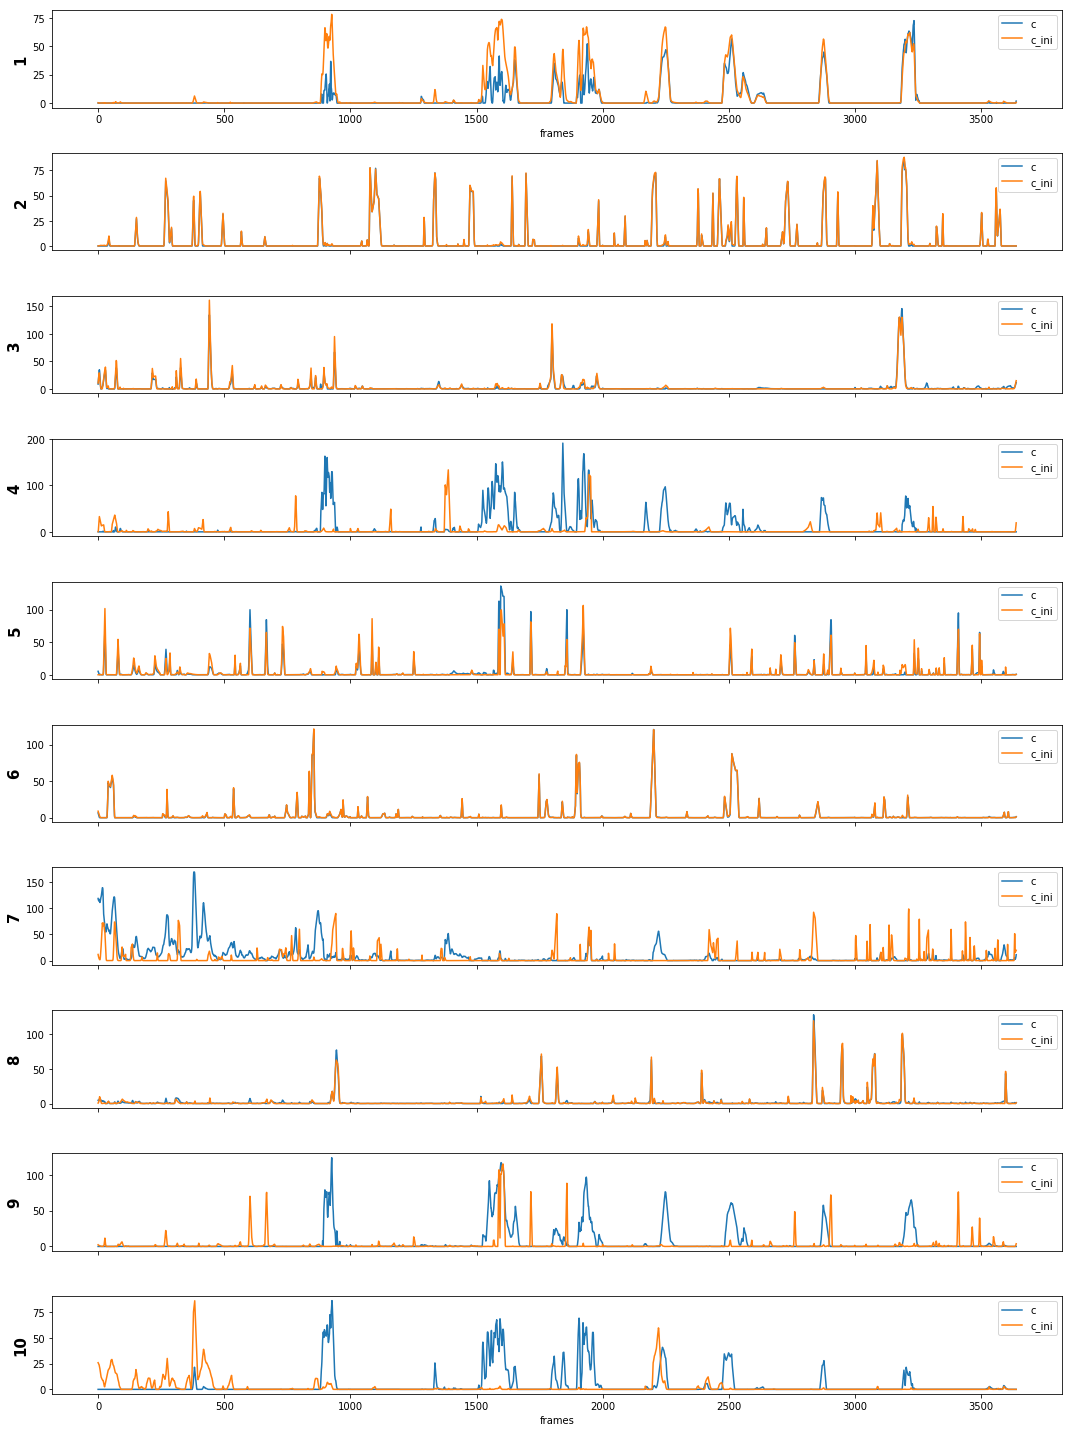

In [160]:
num=len(pure_pix);
fig = plt.figure(figsize=(15,2*num));
for ii in range(num):
    plt.subplot(num,1,ii+1);
    plt.plot(H1[ii,:],label="c");
    plt.plot(c_ini[:,ii],label="c_ini");
    plt.legend()
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout();
#fig.savefig(out_dir + "temp_nmf_patch1.pdf")

In [185]:
sio.savemat(out_dir + 'a_c_l2.mat', mdict={'a': a, 'c':c, 'a_ini':a_ini, 'c_ini':c_ini});
sio.savemat(out_dir + 'a_c_huber.mat', mdict={'a': a3, 'c':c3, 'a_ini':a_ini3, 'c_ini':c_ini3});

In [206]:
Ys = np.matmul(a3, c3.T).reshape((down-up+1),(right-left+1),T,order="F");
Ys2 = np.matmul(a, c.T).reshape((down-up+1),(right-left+1),T,order="F");
#Ys = np.matmul(W1, H1).reshape((down-up+1),(right-left+1),T,order="F");
Yt_1 = Yt[up:(down+1),left:(right+1),:].transpose([2,0,1]);
Ys_1 = Ys.transpose([2,0,1]);
Rt_1 = Yt_1 - Ys_1;
Yt_1 = Yt_1 - Yt_1.min(axis=0, keepdims=True);
Ys_1 = Ys_1 - Ys_1.min(axis=0, keepdims=True);

In [207]:
Yt_1 = (Yt_1 - Yt_1.min())/(Yt_1.max() - Yt_1.min())*255;
Ys_1 = (Ys_1 - Ys_1.min())/(Ys_1.max() - Ys_1.min())*255
Rt_1 = (Rt_1 - Rt_1.min())/(Rt_1.max() - Rt_1.min())*255

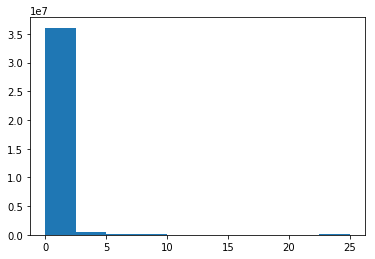

In [208]:
plt.hist(np.clip(Yt_1,0,25).ravel());
Yt_1 = np.clip(Yt_1,0,2.5);

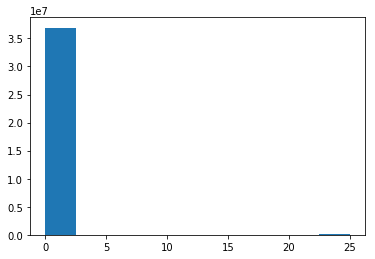

In [209]:
plt.hist(np.clip(Ys_1,0,25).ravel());
Ys_1 = np.clip(Ys_1,0,2.5);

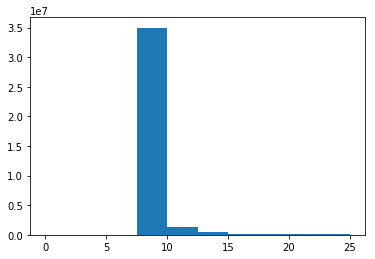

In [213]:
plt.hist(np.clip(Rt_1,0,25).ravel());
Rt_1 = np.clip(Rt_1,7.5,12.5);
#Rt_1 = np.clip(Rt_1,70,80);
#Rt_1 = np.clip(Rt_1,117.5,122.5);

In [221]:
Yt_1 = (Yt_1 - Yt_1.min())/(Yt_1.max() - Yt_1.min())*255;
Ys_1 = (Ys_1 - Ys_1.min())/(Ys_1.max() - Ys_1.min())*255;
Rt_1 = (Rt_1 - Rt_1.min())/(Rt_1.max() - Rt_1.min())*255

In [223]:
Frame=np.concatenate([Yt_1,Ys_1,Rt_1],axis=2);

In [223]:
import skvideo.io
outputdata = Frame
writer = skvideo.io.FFmpegWriter(out_dir + "huber_constrain_nmf_patch2.mp4")
for i in range(T):
    writer.writeFrame(outputdata[i, :, :])
writer.close()